In [1]:
library(glmnet)
library(superheat)

Loading required package: Matrix
Loading required package: foreach
Loaded glmnet 2.0-16



In [2]:
load('../data/organSystem.Rdata')

In [106]:
normalize <- function(x){return(x / sum(x))}

In [7]:
get_os_prediction_from_PP <- function(A.matrix, os){
    # A.matrix is the matrix of pp coefficients
    
    # change column headings to match with os data
    genes <- gsub('\\..*', '', colnames(A.matrix))
    genes <- gsub('\\_.*', '', genes)
        
    # extract those genes for which we have annotations
    A.matrix <- A.matrix[ , genes %in% rownames(os)] 
    
    os.subset <- os[genes[genes %in% rownames(os)], ]
    
    print(dim(os.subset))
    print(dim(A.matrix))
        
    # get the late stage annotations
    # they have names *_4
    os.names <- colnames(os)
    CV.late4 <- os.names[grep("_4", os.names)]

    CV.late4 <- CV.late4[CV.late4 != 'imagPR_4'] # not enough genes w this annotation
    
    coefficients <- matrix(0, dim(A.matrix)[1] + 1, length(CV.late4))
    error_lasso_PP <- matrix(0,length(CV.late4), 1)

    for(i in 1:length(CV.late4)){
        y <- os.subset[, CV.late4[i]]

        cvfit <- cv.glmnet(t(A.matrix), y, family = 'binomial', 
                           type.measure = "auc")
        coefficients[,i] <- as.matrix(coef(cvfit, s = "lambda.1se"))
        error_lasso_PP[i, ] <- cvfit$cvm[cvfit$lambda == cvfit$lambda.1se]
    }

    rownames(coefficients) <- c('intercept', rownames(A.matrix))
    colnames(coefficients) <- sub("_4*", " ", CV.late4)

    rownames(error_lasso_PP) <- sub("_4*", " ", CV.late4)

    coeff_no_int <- coefficients[2:dim(coefficients)[1], ]
    
    return(list(coefficients = coeff_no_int, 
                error = error_lasso_PP))
}

# Predictions with 19 PPs

In [8]:
alpha_file <- '../scripts/staNMFDicts/K=19/alpha_99.csv'
alpha19 <- read.csv(alpha_file)[, -1]

In [9]:
lasso_pred19 <- get_os_prediction_from_PP(alpha19, os)

[1] 658  80
[1]  19 658


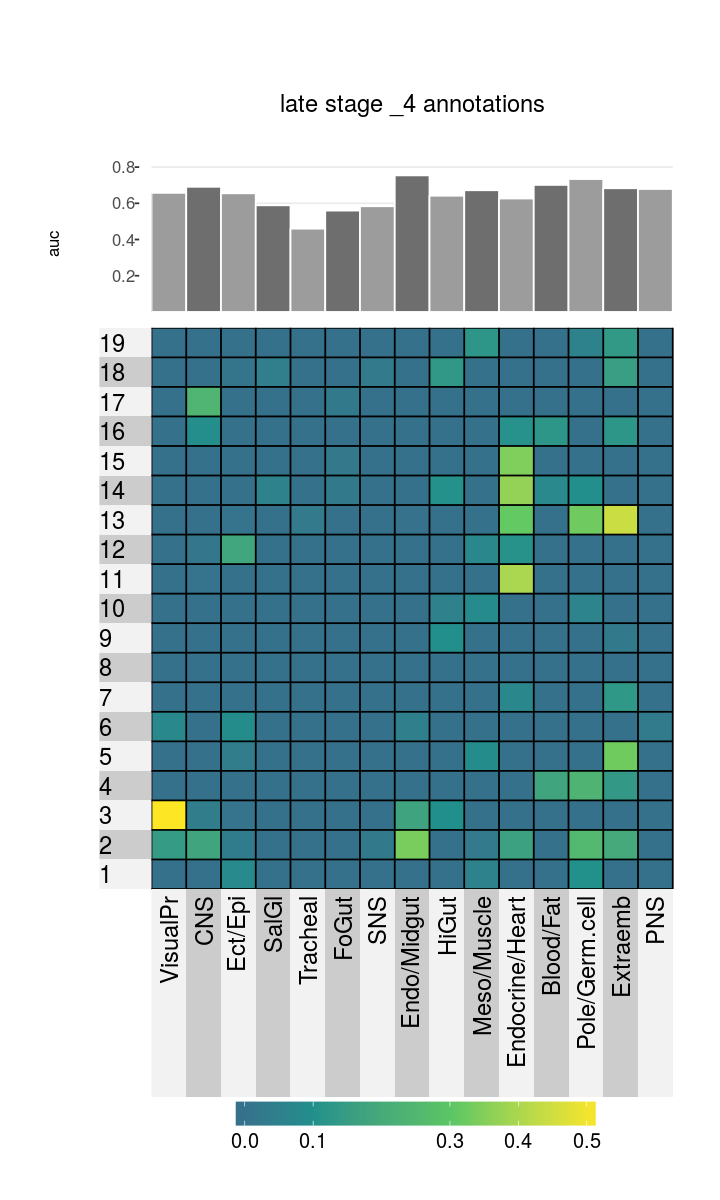

In [128]:
options(repr.plot.width = 6, repr.plot.height = 10)

superheat(abs(lasso_pred19$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right",
          yt = lasso_pred19$error, yt.axis.name = "auc",
          yt.plot.type = "bar", title = "late stage _4 annotations")


In [40]:
dict <- read.csv('../scripts/staNMFDicts/K=19/factorization_99.csv', header = FALSE)[, -1]

In [41]:
source('../utils/plottingUtilities.R')

Loading required package: scales

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: gridExtra

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: grid


In [58]:
dim(lasso_pred19$coefficients)

[1] 19 15

In [101]:
j <- 15

In [103]:
lasso_pred19$coefficients

,VisualPr,CNS,Ect/Epi,SalGl,Tracheal,FoGut,SNS,Endo/Midgut,HiGut,Meso/Muscle,Endocrine/Heart,Blood/Fat,Pole/Germ.cell,Extraemb,PNS
1,0.00000000,0.000000000,-0.082674574,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.05794302,0.00000000,0.00000000,-0.10655221,0.00000000,0.00000000
2,-0.14527893,-0.177692022,-0.037912045,0.00000000,0.00000000,0.00000000,-0.02802194,0.335919174,0.00000000,0.02893540,-0.16534361,0.00000000,0.25196989,0.19640138,0.00000000
3,0.51401749,0.040025599,0.005306867,0.00000000,0.00000000,0.00000000,0.00000000,-0.173789665,-0.10253450,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
4,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.17841787,-0.23469461,0.13799365,0.00000000
5,0.00000000,0.000000000,-0.040933807,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.09051181,0.00000000,0.00000000,0.00000000,-0.32624996,0.00000000
6,-0.07630577,0.000000000,-0.090392828,0.00000000,0.00000000,0.00000000,0.00000000,0.050236351,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,-0.03364607
7,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,-0.07256641,0.00000000,0.00000000,-0.13282676,0.00000000
8,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000,0.00000000
9,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.10065387,0.00000000,0.00000000,0.00000000,0.00000000,-0.02544336,0.00000000
10,0.00000000,0.000000000,0.000000000,0.00000000,0.00000000,0.00000000,0.00000000,0.000000000,0.05323793,0.08687402,0.00000000,0.00000000,-0.06344463,0.00000000,0.00000000


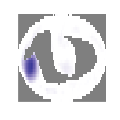

In [102]:
which_dict <- which(lasso_pred19$coefficients[, j] != 0)
p <- list()
for (i in 1:length(which_dict)){
    p[[i]] <- plotImg(dict[, which_dict[i]], late$template, FALSE, paste0('PP', which_dict[i]))
}
options(repr.plot.width = length(p), repr.plot.height = 1.0)
multiplot(plotlist = p, cols = length(p))

# predictions using 8 PPs

In [26]:
alpha_file <- '../scripts/staNMFDicts/K=8/alpha_99.csv'
alpha8 <- read.csv(alpha_file)[, -1]

In [27]:
lasso_pred8 <- get_os_prediction_from_PP(alpha8, os)

[1] 658  80
[1]   8 658


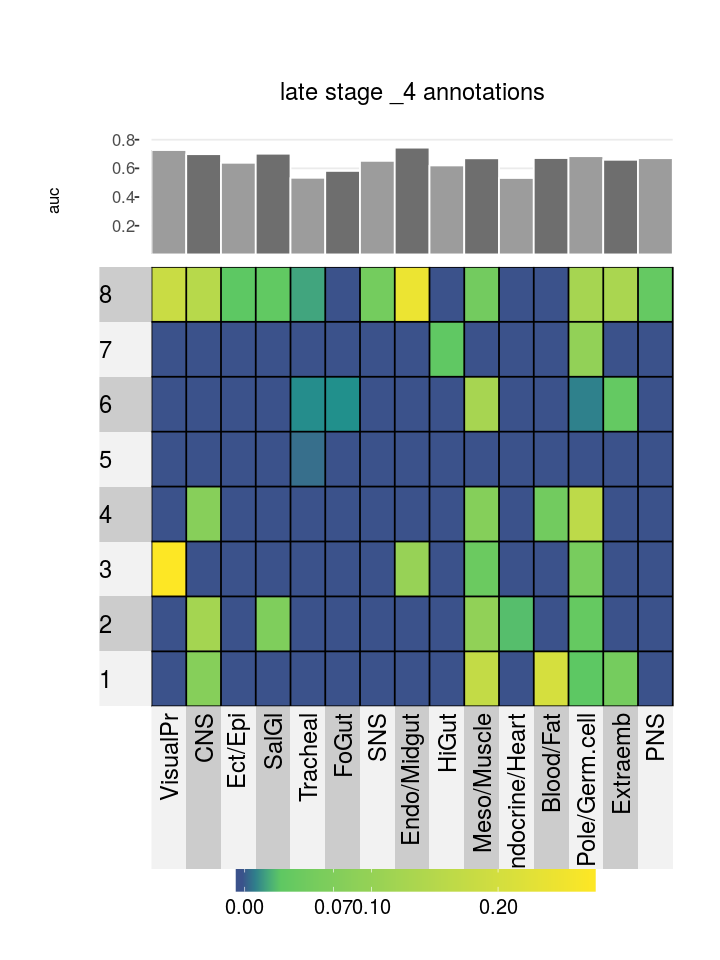

In [28]:
options(repr.plot.width = 6, repr.plot.height = 8)

superheat(abs(lasso_pred8$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right", 
          yt = lasso_pred5$error, yt.axis.name = "auc",
          yt.plot.type = "bar", title = "late stage _4 annotations")


# predictions using 12 PPs

In [29]:
alpha_file <- '../scripts/staNMFDicts/K=12/alpha_99.csv'
alpha12 <- read.csv(alpha_file)[, -1]

In [30]:
lasso_pred12 <- get_os_prediction_from_PP(alpha12, os)

[1] 658  80
[1]  12 658


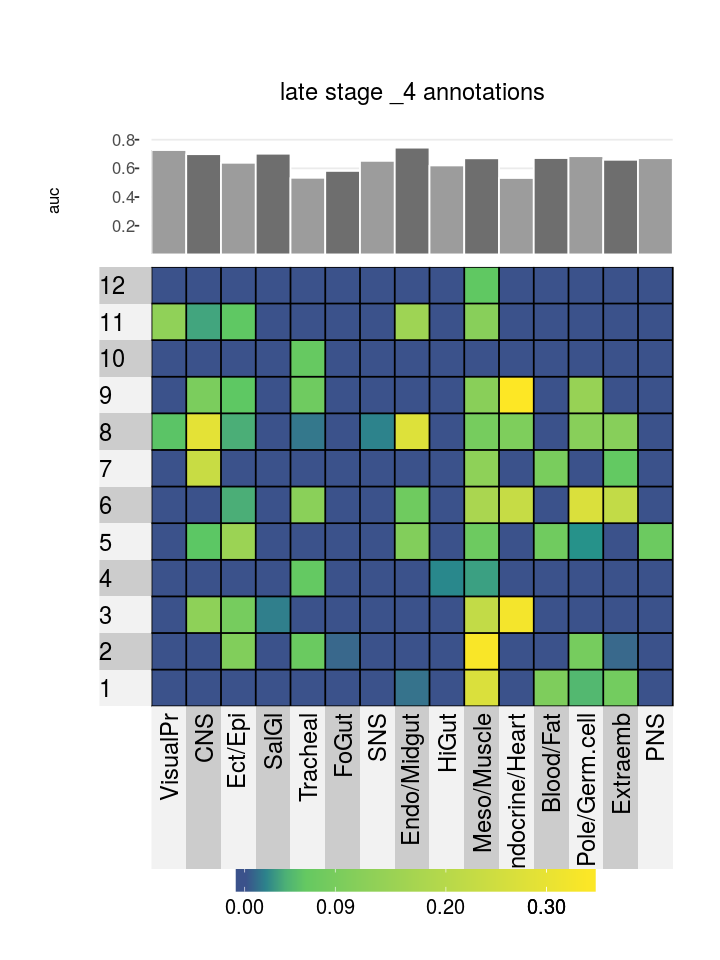

In [31]:
options(repr.plot.width = 6, repr.plot.height = 8)

superheat(abs(lasso_pred12$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right", 
          yt = lasso_pred5$error, yt.axis.name = "auc",
          yt.plot.type = "bar", title = "late stage _4 annotations")


# predictions using 5 PPs

In [11]:
alpha_file <- '../scripts/staNMFDicts/K=5/alpha_99.csv'
alpha5 <- read.csv(alpha_file)[, -1]

In [12]:
lasso_pred5 <- get_os_prediction_from_PP(alpha5, os)

[1] 658  80
[1]   5 658


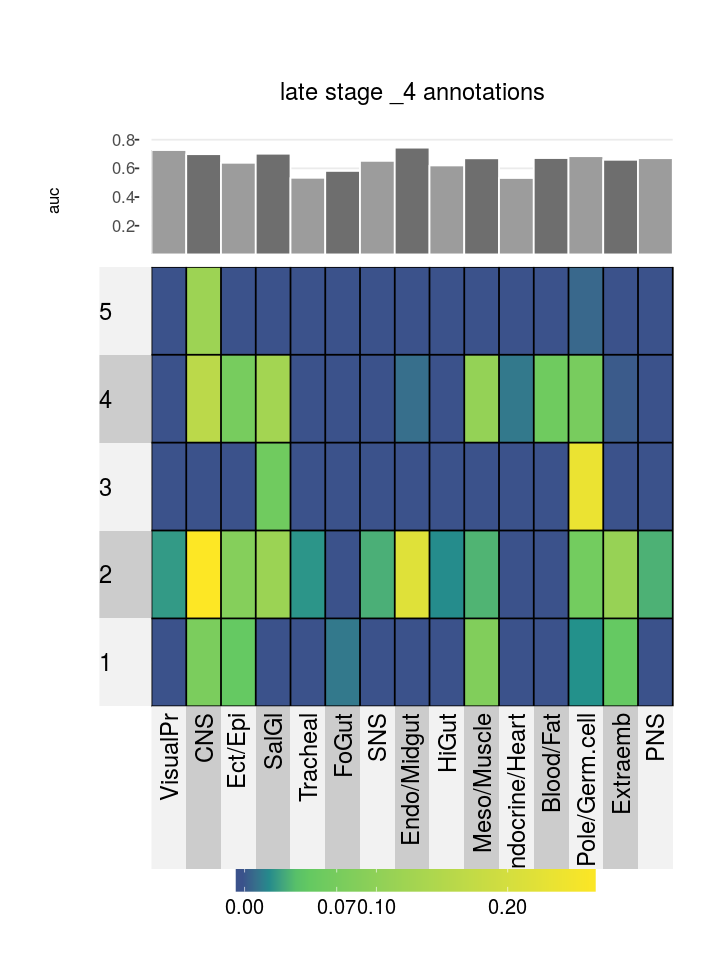

In [15]:
options(repr.plot.width = 6, repr.plot.height = 8)

superheat(abs(lasso_pred5$coefficients), bottom.label.text.angle = 90, left.label.text.alignment = "left",
          bottom.label.text.alignment = "right", 
          yt = lasso_pred5$error, yt.axis.name = "auc",
          yt.plot.type = "bar", title = "late stage _4 annotations")


In [22]:
load('../data/lateData.Rdata')

In [23]:
# predictions using full image

In [24]:
rownames(late$x) <- 1:dim(late$x)[1]

In [25]:
lasso_pred_full <- get_os_prediction_from_PP(late$x, os)

[1] 766  80
[1] 1143  766


In [32]:
os.names <- colnames(os)
CV.late4 <- os.names[grep("_4", os.names)]
CV.late4 <- CV.late4[CV.late4 != 'imagPR_4']

# dataframe for full data
error_lasso_full_ <- lasso_pred_full$error
rownames(error_lasso_full_) <- c()
error_lasso_full_df <- data.frame(auc = error_lasso_full_, os = sub("_4*", " ", CV.late4))
error_lasso_full_df$features <- 'full'

# dataframe for 19 PP
error_lasso19_ <- lasso_pred19$error
rownames(error_lasso19_) <- c()
error_lasso19_df <- data.frame(auc = error_lasso19_, os = sub("_4*", " ", CV.late4))
error_lasso19_df$features <- '19_PP'

# dataframe for 12 PP
error_lasso12_ <- lasso_pred12$error
rownames(error_lasso12_) <- c()
error_lasso12_df <- data.frame(auc = error_lasso12_, os = sub("_4*", " ", CV.late4))
error_lasso12_df$features <- '12_PP'

# dataframe for 8 PP
error_lasso8_ <- lasso_pred8$error
rownames(error_lasso8_) <- c()
error_lasso8_df <- data.frame(auc = error_lasso8_, os = sub("_4*", " ", CV.late4))
error_lasso8_df$features <- '08_PP'

# dataframe for 5 PP
error_lasso5_ <- lasso_pred5$error
rownames(error_lasso5_) <- c()
error_lasso5_df <- data.frame(auc = error_lasso5_, os = sub("_4*", " ", CV.late4))
error_lasso5_df$features <- '05_PP'



In [33]:
library(tidyverse)

Loading tidyverse: ggplot2
Loading tidyverse: tibble
Loading tidyverse: tidyr
Loading tidyverse: readr
Loading tidyverse: purrr
Loading tidyverse: dplyr
Conflicts with tidy packages ---------------------------------------------------
accumulate(): purrr, foreach
expand():     tidyr, Matrix
filter():     dplyr, stats
lag():        dplyr, stats
when():       purrr, foreach


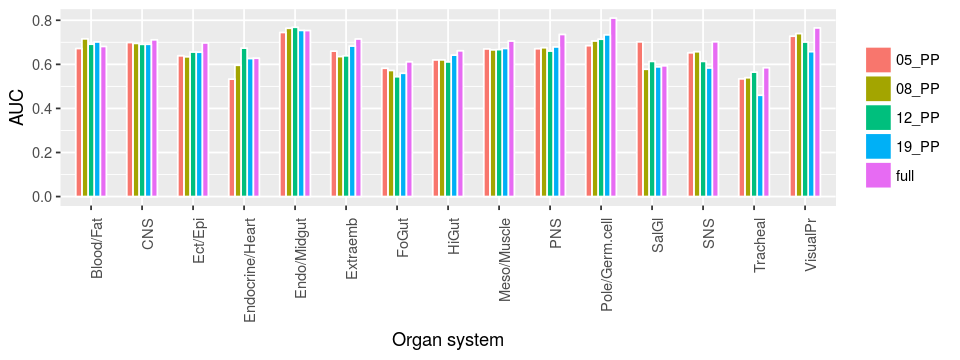

In [38]:
error_df <- rbind(error_lasso19_df, error_lasso12_df, error_lasso8_df, error_lasso5_df, error_lasso_full_df)

blank_theme <-   theme_bw() +
  theme(axis.line = element_line(colour = "black"),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    panel.border = element_blank(),
    panel.background = element_blank()) 


library(ggplot2)
library(repr)
options(repr.plot.width=8, repr.plot.height=3)

ggplot(error_df ,aes(x=os,y=auc,fill=factor(features), width=.6))+
  geom_bar(stat="identity",position="dodge", color = 'white')+
  xlab("Organ system")+ylab("AUC") + theme(axis.text.x=element_text(angle=90,hjust=1)) +  
guides(fill=guide_legend(title="")) 

